In [22]:
install.packages("pdp")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [23]:
setwd('/Users/alexis/University of North Carolina at Chapel Hill - Rager, Julia - CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.4. ML Visualizations/P1003.3.4.2. ICE Plot/Input')
Output = ('/Users/alexis/University of North Carolina at Chapel Hill/Rager, Julia - CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.4. ML Visualizations/P1003.3.4.2. ICE Plot/Output')
cur_date = "040122"

library(readxl)
library(tidyverse)
library(pdp)
library(caret)
library(randomForest)

#reading in files
ozone_data = data.frame(read_excel("Imputed_Ozone_Data_022822.xlsx")) 
demographics_data = data.frame(read_excel("SubjectInfo_011822.xlsx", sheet = 2))


Attaching package: ‘pdp’


The following object is masked from ‘package:purrr’:

    partial




In [24]:
head(ozone_data)
head(demographics_data)

,Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Sample_Type,Time_Point,Inflammatory_Responder,Lung_Responder,Category,Variable,Value
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Sample_Weight,817.00
2,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,TCC,395000.00
3,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,TCC_Weight,483.48
4,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils_Percent,25.00
5,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils,98750.00
6,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils_Weight,121.00


,Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,4,1,AS_1,M,W,NH,30,23.3,AS,Fa
2,7,2,AS_2,F,W,NH,39,32.7,AS,Sp
3,11,3,AS_3,M,W,NH,23,23.0,AS,Fa
4,13,4,AS_4,M,W,NH,20,21.4,AS,Wi
5,15,5,AS_5,F,B,NH,20,34.5,AS,Su
6,16,6,AS_6,F,W,NH,25,25.2,AS,Su


Making an Individual Conditional Expectation (ICE) plot to highlight Vitamin D and how it's importance fluctuates with the overall predictability of lung function in a random forest model. 

TALK MORE ABOUT ICE PLOTS

In [25]:
#getting baseline plasma data (not using covariates)
plasma_baseline_ozone_data = ozone_data %>%
    #only interested in plasma soluble mediators (cytokines/sterols) at baseline
    filter(Sample_Type == "P" & Time_Point == "Pre") %>%
    filter(Category == "Cytokine" | Category == "Sterol") %>%
    select(-c("Sample_Type", "Time_Point", "Category")) %>%
    distinct()
head(plasma_baseline_ozone_data)

,Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Inflammatory_Responder,Lung_Responder,Variable,Value
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,4,1,AS_1,AS,NR,NR,IFNg,8.0557406
2,4,1,AS_1,AS,NR,NR,IL10,0.3476302
3,4,1,AS_1,AS,NR,NR,IL12p70,0.4572941
4,4,1,AS_1,AS,NR,NR,IL13,7.7955008
5,4,1,AS_1,AS,NR,NR,IL1b,0.2763808
6,4,1,AS_1,AS,NR,NR,IL2,0.5728830


In [26]:
#first pivoting wider bc thats what random forest prefers
wider_data = pivot_wider(plasma_baseline_ozone_data,
                         #not actually taking the mean of multiple values
                         #did this bc cols would be type list rather than double
                         names_from = Variable, values_from = Value, values_fn = mean)

head(wider_data)

Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Inflammatory_Responder,Lung_Responder,IFNg,IL10,IL12p70,IL13,⋯,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,AS_1,AS,NR,NR,8.055741,0.3476302,0.4572941,7.795501,⋯,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
7,2,AS_2,AS,R,NR,5.456212,0.1802846,0.1292934,2.917929,⋯,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
11,3,AS_3,AS,NR,R,2.902175,0.4177936,0.2590372,5.633180,⋯,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
13,4,AS_4,AS,R,NR,3.860980,0.3901140,0.2232882,5.927085,⋯,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
15,5,AS_5,AS,R,NR,2.652720,0.2658850,0.4454673,4.514058,⋯,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
16,6,AS_6,AS,NR,NR,22.007931,0.4377489,0.1994178,4.951412,⋯,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


In [27]:
#making responder columns binary denoted by 0 = non-responder and 1 = responder 
wider_data = wider_data %>%
    mutate(Lung_Responder = relevel(factor(ifelse(Lung_Responder == "R", 1, 0)), ref = "0")) %>%
    #for some reason RF didn't this variable so I changed it
    rename(X25OH_VitD = `25OH_VitD`)
lung_resp_df = wider_data[,6:47]

head(lung_resp_df)

Lung_Responder,IFNg,IL10,IL12p70,IL13,IL1b,IL2,IL4,IL6,IL8,⋯,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,8.055741,0.3476302,0.4572941,7.795501,0.2763808,0.5728830,0.08653851,4.27020432,624.862506,⋯,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
0,5.456212,0.1802846,0.1292934,2.917929,0.1416200,0.0616800,0.00492000,0.22680099,28.767470,⋯,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
1,2.902175,0.4177936,0.2590372,5.633180,0.1416200,0.0616800,0.03890678,0.15432565,4.411786,⋯,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
0,3.860980,0.3901140,0.2232882,5.927085,0.1416200,0.1127180,0.03740718,0.47849981,2.909993,⋯,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
0,2.652720,0.2658850,0.4454673,4.514058,0.1416200,0.0616800,0.02353853,0.07186388,3.387921,⋯,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
0,22.007931,0.4377489,0.1994178,4.951412,0.1416200,0.2333793,0.02990994,1.54397048,3.779592,⋯,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


# Random Forest

In [58]:
rf_classification = function(dataset, outcome, pred_outcome){
    # setting for reproducibility
    set.seed(12)
    # splitting data into training and testing sets
    dataset_index = createFolds(dataset[[outcome]], k = 5) # 5 fold CV

    rf_models = list()
    
    for (i in 1:length(dataset_index)){
        data_train = dataset[-dataset_index[[i]],]
        data_test = dataset[dataset_index[[i]],]

        ntree_values = c(50, 250, 500) # number of trees (not sure if we wanted something different)
        p = dim(dataset)[2] - 1 # number of variables in dataset
        mtry_values = c(p/2, sqrt(p), p)

        # will use ntree and mtry values to determine which combination yields the smallest MSE
        reg_rf_pred_tune = list()
        rf_OOB_errors = list()
        rf_error_df = data.frame()
        for (j in 1:length(ntree_values)){
            for (k in 1:length(mtry_values)){
                reg_rf_pred_tune[[k]] = randomForest(as.formula(paste0(outcome, "~.")), data = data_train, 
                                                     ntree = ntree_values[j], mtry = mtry_values[k])
                rf_OOB_errors[[k]] = data.frame("Tree Number" = ntree_values[j], "Variable Number" = mtry_values[k], 
                                       "OOB_errors" = reg_rf_pred_tune[[k]]$err.rate[ntree_values[j],1])
                rf_error_df = rbind(rf_error_df, rf_OOB_errors[[k]])
            }
        }

        # finding the lowest OOB error using best number of predictors at split and refitting OG tree
        best_oob_errors <- which(rf_error_df$OOB_errors == min(rf_error_df$OOB_errors))

        reg_rf <- randomForest(as.formula(paste0(outcome, "~.")), data = data_train,
        # need to go back and figure out how the number of trees/ variables make a difference even though
        # the errors are the same!!!!
                               ntree = rf_error_df$Tree.Number[min(best_oob_errors)], 
                               mtry = rf_error_df$Variable.Number[min(best_oob_errors)])

        rf_models = list(rf_models, reg_rf)
        
#         X <- lung_resp_df[which(names(lung_resp_df) != "Lung_Responder")]
#         plot = partialPlot(rf_models_lung_resp[[1]], pred.data = X, x.var = "X25OH_VitD")  # Figure 2
    }
    
    # return each rf model
    return(rf_models)

}

#calling fn
rf_models_lung_resp = rf_classification(lung_resp_df, "Lung_Responder", "pred_Lung_Responder")

In [59]:
rf_models_lung_resp

[[1]]
[[1]][[1]]
[[1]][[1]][[1]]
[[1]][[1]][[1]][[1]]
[[1]][[1]][[1]][[1]][[1]]
list()

[[1]][[1]][[1]][[1]][[2]]

Call:
 randomForest(formula = as.formula(paste0(outcome, "~.")), data = data_train,      ntree = rf_error_df$Tree.Number[min(best_oob_errors)], mtry = rf_error_df$Variable.Number[min(best_oob_errors)]) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 20

        OOB estimate of  error rate: 55%
Confusion matrix:
  0 1 class.error
0 2 7   0.7777778
1 4 7   0.3636364


[[1]][[1]][[1]][[2]]

Call:
 randomForest(formula = as.formula(paste0(outcome, "~.")), data = data_train,      ntree = rf_error_df$Tree.Number[min(best_oob_errors)], mtry = rf_error_df$Variable.Number[min(best_oob_errors)]) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 20

        OOB estimate of  error rate: 33.33%
Confusion matrix:
  0 1 c

In [69]:
first_model


Call:
 randomForest(formula = as.formula(paste0(outcome, "~.")), data = data_train,      ntree = rf_error_df$Tree.Number[min(best_oob_errors)], mtry = rf_error_df$Variable.Number[min(best_oob_errors)]) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 20

        OOB estimate of  error rate: 55%
Confusion matrix:
  0 1 class.error
0 2 7   0.7777778
1 4 7   0.3636364

ERROR: Error in is.finite(x): default method not implemented for type 'list'


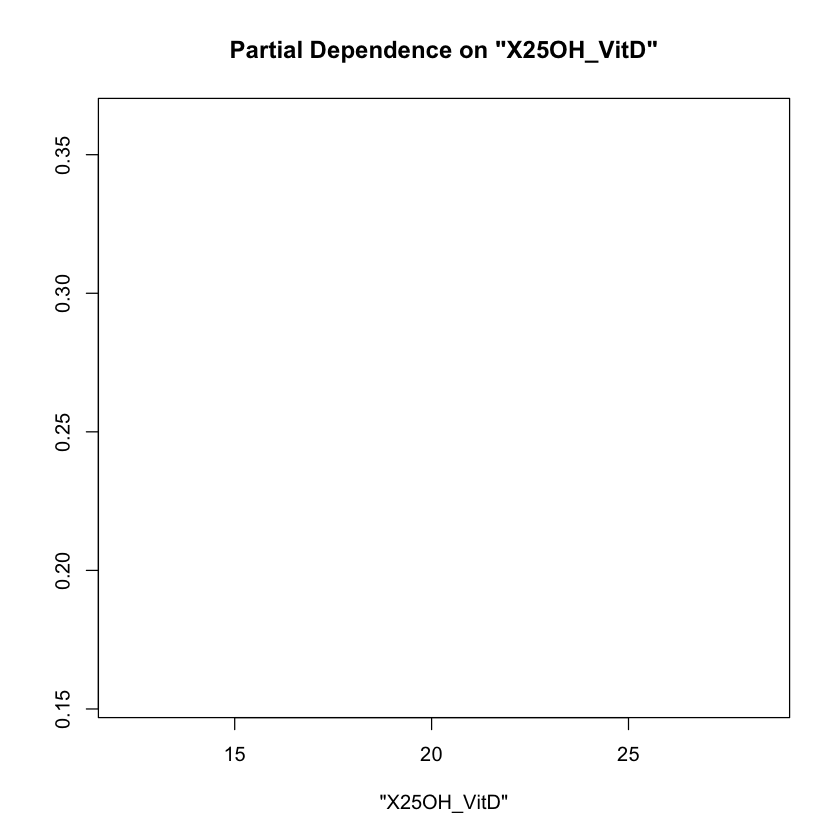

In [64]:
first_model = rf_models_lung_resp[[1]][[1]][[1]][[1]][[2]]
X <- lung_resp_df[which(names(lung_resp_df) != "Lung_Responder")]
partialPlot(first_model, pred.data = X, x.var = "X25OH_VitD")  # Figure 2

In [12]:
X <- lung_resp_df[which(names(lung_resp_df) != "Lung_Responder")]
predictor <- Predictor$new(rf_models_lung_resp[[1]], data = X, y = lung_resp_df$Lung_Responder)

In [15]:
imp <- FeatureImp$new(predictor, loss = "mae")
#library("ggplot2")
plot(imp)

ERROR: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 0, 24
